In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.similarities.docsim import Similarity
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from gensim.models import Word2Vec, Doc2Vec
from bs4 import BeautifulSoup
import re
import nltk.data
import string
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim import matutils
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.keyedvectors import KeyedVectors

In [3]:
iteminfo_train = pd.read_csv('ItemInfo_train.csv')
#iteminfo_test = pd.read_csv('ItemInfo_test.csv')

In [4]:
itempairs_train = pd.read_csv('ItemPairs_train.csv')
#itempairs_test = pd.read_csv('ItemPairs_test.csv')

In [5]:
location = pd.read_csv('Location.csv')
category = pd.read_csv('Category.csv')

In [6]:
iteminfo_train_loc = pd.merge(pd.merge(iteminfo_train, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')
#iteminfo_test_loc = pd.merge(pd.merge(iteminfo_test, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')

In [7]:
x = pd.merge(pd.merge(itempairs_train, iteminfo_train_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
                    iteminfo_train_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')
#x_test = pd.merge(pd.merge(itempairs_test, iteminfo_test_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
#                    iteminfo_test_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')

In [8]:
x['title_x'] = x.title_x.map(lambda x : '' if pd.isnull(x) else x)
x['title_y'] = x.title_y.map(lambda x : '' if pd.isnull(x) else x)
x['description_x'] = x.description_x.map(lambda x : '' if pd.isnull(x) else x)
x['description_y'] = x.description_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_x'] = x_test.title_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_y'] = x_test.title_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_x'] = x_test.description_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_y'] = x_test.description_y.map(lambda x : '' if pd.isnull(x) else x)

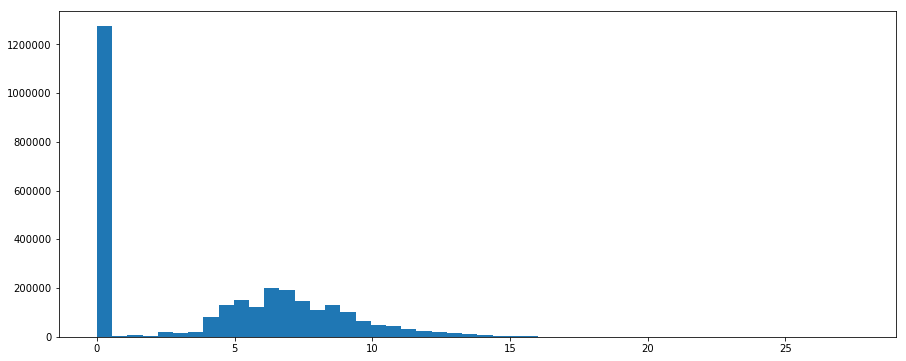

In [8]:
x['price_diff'] = abs(x.price_x - x.price_y).map(lambda x : 0 if np.isnan(x) else 0 if x == 0 else math.log(x))
figure = plt.figure(figsize=(15,6))
plt.hist(x.price_diff, bins = 50)
plt.show()

In [ ]:
figure = plt.figure(figsize=(15,6))
plt.hist(np.array(x.price_diff)[np.where(x.price_diff != 0)], bins = 50)
plt.show()

## Images
Finding difference in number of images between the two items

In [54]:
x['images_array_x'] =  x['images_array_x'].apply(lambda s : len(s.split()) if isinstance(s, str) else 0)
x['images_array_y'] =  x['images_array_y'].apply(lambda s : len(s.split()) if isinstance(s, str) else 0)
x['images_num_diff'] = x[['images_array_x', 'images_array_y']].apply(lambda s: abs(s[0] - s[1]), axis = 1)

In [ ]:
x.groupby('images_num_diff').count()['itemID_1']

In [ ]:
figure = plt.figure(figsize=(15,6))
images_num_diff_counts = x.groupby('images_num_diff').count()['itemID_1']
plt.bar(range(len(images_num_diff_counts)), images_num_diff_counts)
plt.show()

## Location Distance

In [51]:
x['region_dist'] = abs(x.regionID_x - x.regionID_y)

In [26]:
x['loc_dist'] = np.abs(x['lat_x']-x['lat_y']) + np.abs(x['lon_x']-x['lon_y'])

## Computing Similarity

In [2]:
def clean_text(document):    
    # Removes punctuations
    document = document.translate(string.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    # Change to lowercase
    document = document.lower()
    
    # Removes newline characters
    document = ' '.join(document.split('\n'))
    
    # Replace multiple spaces with one space
    document = ' '.join(document.split())
    #document = nlp(unicode(document))
    
    return document

def word_vec(x, model, num_features):
    try:
        a = model[x]
        b = 1
    except KeyError:
        a = np.zeros(num_features)
        b = 0
    return [a,b]

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    
    for word in words:
        a, b = word_vec(word, model, num_features)
        nwords = nwords + b
        featureVec = np.add(featureVec, a)
    # 
    # Divide the result by the number of words to get the average
    if nwords != 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [23]:
# Word2Vec
sentences_desc_x = []
sentences_desc_y = []
for i in range(len(x.description_x)):
    if i in [10, 500000, 1000000, 1500000, 2000000]:
        print i
    sentences_desc_x.append(clean_text(x.description_x[i]))
    sentences_desc_y.append(clean_text(x.description_y[i]))
pd.DataFrame(sentences_desc_x, columns = ['sentences_desc_x']).to_csv('sentences_desc_x.csv')
pd.DataFrame(sentences_desc_y, columns = ['sentences_desc_y']).to_csv('sentences_desc_y.csv')
del sentences_desc_x
del sentences_desc_y

10
500000
1000000
1500000
2000000


In [24]:
sentences_title_x = []
sentences_title_y = []
for i in range(len(x.title_x)):
    if i in [10, 500000, 1000000, 1500000, 2000000]:
        print i
    sentences_title_x.append(clean_text(x.title_x[i]))
    sentences_title_y.append(clean_text(x.title_y[i]))
pd.DataFrame(sentences_title_x, columns = ['sentences_title_x']).to_csv('sentences_title_x.csv')
pd.DataFrame(sentences_title_y, columns = ['sentences_title_y']).to_csv('sentences_title_y.csv')
del sentences_title_x
del sentences_title_y

10
500000
1000000
1500000
2000000


In [55]:
new_x = pd.DataFrame(np.column_stack([x.images_num_diff, x.price_diff, x.parentCategoryID_x, x.isDuplicate, x.loc_dist, x.region_dist]), columns = ['images_num_diff', 'price_diff', 'parentCategoryID_x', 'isDuplicate', 'loc_dist', 'region_dist'])
new_x.to_csv('new_x.csv')
del new_x

In [3]:
sentences_desc_x = pd.read_csv('sentences_desc_x.csv')
sentences_desc_y = pd.read_csv('sentences_desc_y.csv')
sentences_title_x = pd.read_csv('sentences_title_x.csv')
sentences_title_y = pd.read_csv('sentences_title_y.csv')
x = pd.read_csv('new_x.csv')

In [4]:
del sentences_desc_x['Unnamed: 0']
del sentences_desc_y['Unnamed: 0']
del sentences_title_x['Unnamed: 0']
del sentences_title_y['Unnamed: 0']
del x['Unnamed: 0']

In [5]:
kf = KFold(n_splits = 5, random_state = 1)
train_score = []
test_score = []
log_reg = LogisticRegression()
i = 0
sentences_desc_x = np.array(sentences_desc_x.sentences_desc_x.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))
sentences_desc_y = np.array(sentences_desc_y.sentences_desc_y.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))
sentences_title_x = np.array(sentences_title_x.sentences_title_x.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))
sentences_title_y = np.array(sentences_title_y.sentences_title_y.map(lambda x : x.split() if isinstance(x, basestring) else str(x)))


In [6]:
train_index, test_index = list(kf.split(x))[0]

In [7]:
sentences_desc_x_train = sentences_desc_x[train_index]
sentences_desc_y_train = sentences_desc_y[train_index]
sentences_desc_x_test = sentences_desc_x[test_index]
sentences_desc_y_test = sentences_desc_y[test_index]
sentences_title_x_train = sentences_title_x[train_index]
sentences_title_y_train = sentences_title_y[train_index]
sentences_title_x_test = sentences_title_x[test_index]
sentences_title_y_test = sentences_title_y[test_index]

In [8]:
training_corpus = np.concatenate((sentences_desc_x_train, sentences_desc_y_train, sentences_title_x_train, sentences_title_y_train))

In [9]:
print 'Training w2v'
model = Word2Vec(training_corpus, min_count = 1, size = 50)

Training w2v


In [10]:
x_train, x_test = x.loc[train_index, :].reset_index(drop = True), x.loc[test_index, :].reset_index(drop = True)

In [11]:
model.save('w2v_full')

In [2]:
model = KeyedVectors.load('w2v_full')

In [13]:
print 'computing training similarity'
cos_sim_desc = []
cos_sim_title = []
trainDuplicate = []
for i in range(len(sentences_desc_x_train)):
    if i in [10, 500000, 1000000, 1500000, 2000000]:
        print i
    value_desc = model.wv.n_similarity(sentences_desc_x_train[i], sentences_desc_y_train[i])
    value_title = model.wv.n_similarity(sentences_title_x_train[i], sentences_title_y_train[i])
    cos_sim_desc.append(value_desc)
    cos_sim_title.append(value_title)
    if value_desc >= 0.5 and value_title >= 0.5:
        if x_train.isDuplicate[i] == 1.0:
            trainDuplicate.append(1)
        else:
            trainDuplicate.append(0)
    else:
        if x_train.isDuplicate[i] == 0.0:
            trainDuplicate.append(1)
        else:
            trainDuplicate.append(0)
print trainDuplicate.count(1)
print len(trainDuplicate)
print float(trainDuplicate.count(1)) / len(trainDuplicate)

computing training similarity
10
500000
1000000
1500000
2000000
1224282
2393116
0.51158489601


In [14]:
model_vocab = set(model.wv.index2word)

In [15]:
def check_word_vec(sent, model_vocab = model_vocab):
    final_sent = []
    for word in sent:
        if word in model_vocab:
            final_sent.append(word)
    return final_sent

In [16]:
cos_sim_desc_test = []
cos_sim_title_test = []
testDuplicate = []
for i in range(len(sentences_desc_x_test)):
    if i in [10, 500000, 1000000, 1500000, 2000000]:
        print i
    sentences_desc_x_testa = check_word_vec(sentences_desc_x_test[i])
    sentences_desc_y_testa = check_word_vec(sentences_desc_y_test[i])
    sentences_title_x_testa = check_word_vec(sentences_title_x_test[i])
    sentences_title_y_testa = check_word_vec(sentences_title_y_test[i])
    if len(sentences_desc_x_testa) and len(sentences_desc_y_testa):
        value_desc = model.wv.n_similarity(sentences_desc_x_testa, sentences_desc_y_testa)
    if len(sentences_title_x_testa) and len(sentences_title_y_testa):
        value_title = model.wv.n_similarity(sentences_title_x_testa, sentences_title_y_testa)
    cos_sim_desc_test.append(value_desc)
    cos_sim_title_test.append(value_title)
    if value_desc >= 0.5 and value_title >= 0.5:
        if x_test.isDuplicate[i] == 1.0:
            testDuplicate.append(1)
        else:
            testDuplicate.append(0)
    else:
        if x_test.isDuplicate[i] == 0.0:
            testDuplicate.append(1)
        else:
            testDuplicate.append(0)
print testDuplicate.count(1)
print len(testDuplicate)
print float(testDuplicate.count(1)) / len(testDuplicate)

10
500000
305384
598280
0.510436584877


In [17]:
cos_sim_desc_train_df = pd.DataFrame(cos_sim_desc, columns = ['cos_sim_desc_train'])
cos_sim_desc_test_df = pd.DataFrame(cos_sim_desc_test, columns = ['cos_sim_desc_test'])
cos_sim_title_train_df = pd.DataFrame(cos_sim_title, columns = ['cos_sim_title_train'])
cos_sim_title_test_df = pd.DataFrame(cos_sim_title_test, columns = ['cos_sim_title_test'])

In [18]:
x_train = pd.concat([x_train, cos_sim_desc_train_df, cos_sim_title_train_df], axis = 1)
x_test = pd.concat([x_test, cos_sim_desc_test_df, cos_sim_title_test_df], axis = 1)

In [19]:
kf = KFold(n_splits = 5, random_state = 1)
train_score = []
test_score = []
log_reg = LogisticRegression()
log_reg.fit(x_train.iloc[:, x_train.columns != 'isDuplicate'], np.array(x_train.isDuplicate))
pred_train = log_reg.predict(x_train.iloc[:, x_train.columns != 'isDuplicate'])
pred_test = log_reg.predict(x_test.iloc[:, x_test.columns != 'isDuplicate'])
train_score.append(pred_train)
test_score.append(pred_test)
print "Test Accuracy:", accuracy_score(x_test.isDuplicate, pred_test)
print "Train Accuracy:", accuracy_score(x_train.isDuplicate, pred_train)

Test Accuracy: 0.676868690245
Train Accuracy: 0.676090920791
